In [1]:
import os
import sys
import json
from pathlib import Path
from copy import deepcopy
import time
import inspect

from timeout_decorator import timeout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path

from tqdm.notebook import tqdm

In [2]:
sys.path.insert(0, '../DSL')
import solvers as task_solvers
import verifiers as task_verifiers
from solver_class import Solver

sys.path.insert(0, '../visualization')
from visualization_utils import *

from fitness_scoring import *

In [3]:
data_path = Path('../data')
train_path = data_path / 'arc-agi_training_challenges.json'
train_sols_path = data_path / 'arc-agi_training_solutions.json'
eval_path = data_path / 'arc-agi_evaluation_challenges.json'
eval_sols_path = data_path / 'arc-agi_evaluation_solutions.json'
re_arc_path = data_path / 're-arc_tasks'

In [4]:
with open(train_path, 'r') as f:
    train_tasks = json.load(f)
with open(train_sols_path, 'r') as f:
    train_sols = json.load(f)
with open(eval_path, 'r') as f:
    eval_tasks = json.load(f)
with open(eval_sols_path, 'r') as f:
    eval_sols = json.load(f)
train_task_labels = sorted(train_tasks.keys())
eval_task_labels = sorted(eval_tasks.keys())

In [5]:
ast = lambda g: tuple(tuple(r) for r in g) # Converts grid to tuple format for DSL
asg = lambda t: list(list(r) for r in t) # Convert tuple back to grid

# Convert all train and eval examples to tuples for DSL
for train_label in train_task_labels:
    num_train = len(train_tasks[train_label]['train']) 
    num_test = len(train_tasks[train_label]['test'])
    for i in range(num_train):
        train_tasks[train_label]['train'][i]['input'] = ast(train_tasks[train_label]['train'][i]['input'])
        train_tasks[train_label]['train'][i]['output'] = ast(train_tasks[train_label]['train'][i]['output'])
    for i in range(num_test):
        train_tasks[train_label]['test'][i]['input'] = ast(train_tasks[train_label]['test'][i]['input'])
        train_sols[train_label][i] = ast(train_sols[train_label][i])
for eval_label in eval_task_labels:
    num_train = len(eval_tasks[eval_label]['train']) 
    num_test = len(eval_tasks[eval_label]['test'])
    for i in range(num_train):
        eval_tasks[eval_label]['train'][i]['input'] = ast(eval_tasks[eval_label]['train'][i]['input'])
        eval_tasks[eval_label]['train'][i]['output'] = ast(eval_tasks[eval_label]['train'][i]['output'])
    for i in range(num_test):
        eval_tasks[eval_label]['test'][i]['input'] = ast(eval_tasks[eval_label]['test'][i]['input'])
        eval_sols[eval_label][i] = ast(eval_sols[eval_label][i])

In [6]:
solver_functions = [Solver(inspect.getsource(getattr(task_solvers, f"solve_{label}"))) for label in train_task_labels]
verifier_functions = [Solver(inspect.getsource(getattr(task_verifiers, f"verify_{label}"))) for label in train_task_labels]

In [7]:
#del solver_functions['a64e4611'] # Extremely slow solver
#train_task_labels.remove('a64e4611')

In [8]:
train_scoring_results = {}
#test_scoring_results = {} # TODO: Compute fitness using test in/out as well?

for label in tqdm(eval_task_labels):
    task = eval_tasks[label]
    num_train = len(task['train'])
    num_test = len(task['test'])
    train_results = {}
    test_results = {}

    train_pairs = task['train']

    scoring_results = score_solvers_vs_tasks(solver_functions + verifier_functions, train_pairs, scoring_functions, solver_timeout = 1.0)
    scoring_results = [(score, solver.name) for score, solver in scoring_results]

    # Record the solvers that had the top 5 scores    
    #top_5 = sorted(scoring_results.items(), key = lambda x: x[1])[:5]

    # Record all the solvers and their results
    train_scoring_results[label] = sorted(scoring_results, key = lambda x: x[0])

  0%|          | 0/400 [00:00<?, ?it/s]

In [29]:
with open('fitness data/baseline.json', 'r') as f:
    old_baseline = json.load(f)

In [30]:
equality_rates = {}
for label in old_baseline.keys():
    same_count = 0
    comps = {}
    for score, solver in old_baseline[label]:
        comps[solver] = score
    for score, solver in train_scoring_results[label]:
        if comps[solver] == score:
            same_count += 1
    equality_rates[label] = same_count / len(old_baseline[label])

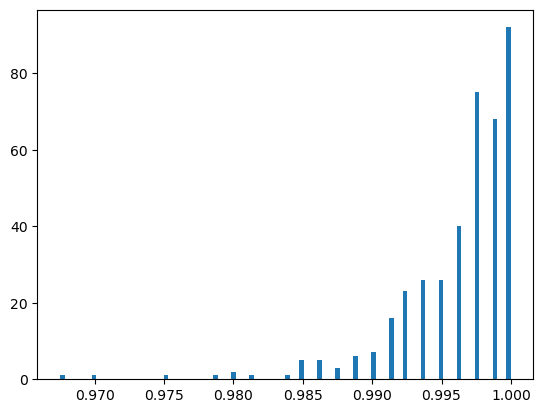

In [34]:
# Results are at least 96% the same for each task
plt.hist(equality_rates.values(), bins = 100)
plt.show()

In [35]:
sorted(equality_rates.values())

[0.9675,
 0.97,
 0.975,
 0.97875,
 0.98,
 0.98,
 0.98125,
 0.98375,
 0.985,
 0.985,
 0.985,
 0.985,
 0.985,
 0.98625,
 0.98625,
 0.98625,
 0.98625,
 0.98625,
 0.9875,
 0.9875,
 0.9875,
 0.98875,
 0.98875,
 0.98875,
 0.98875,
 0.98875,
 0.98875,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.99125,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.9925,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.99375,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,

In [37]:
with open('new_baseline.json', 'w') as f:
    json.dump(train_scoring_results, f, indent = 4)